In [1]:
push!(LOAD_PATH, pwd()*"/../src")

using SeisAcoustic, SeisPlot
using forward: single_source_forward
using gradient: conventional_gradient
using backward: reduced_wavefield_imaging
using utils: MultiSeisPlotTX

In [2]:
# model dimensions
shape = (101, 101) # (nz, nx)
spacing = (10f0, 10f0)

# true velocity and density models
vel = 2000f0*ones(Float32, shape);  
vel[51:101,:] .= 2500f0;
rho = 1500f0*ones(Float32, shape);  

# smooth velocity
vel0 = 2000f0*ones(Float32, shape);  

In [3]:
# aquisition and other SeisAcoustic parameters for FD calculation
free_surface = false
dt = 0.001f0
tmax = 1f0
order = 2
npml = 20;
data_format = Float32
fd_flag = "taylor"

# set SeisAcoustic required structure parameters
# True model
params = TdParams(rho, vel, free_surface, spacing[1], spacing[2], dt, tmax;
                  fd_flag=fd_flag, data_format=data_format, order=order, npml=npml);
# Smooth model
params0= TdParams(rho, vel0, free_surface, spacing[1], spacing[2], dt, tmax;
                  fd_flag=fd_flag, data_format=data_format, order=order, npml=npml);
       

In [4]:
# Source and receivers information

# initialize a source
isz = 10; isx = 51;
src = Source(isz, isx, params; amp=rho[isz,isx]*vel0[isz,isx]*vel0[isz,isx], fdom=10, type_flag="ricker")

# generate observed data
irx = collect(1:1:shape[2]);
irz = 10*ones(Int64, length(irx));

In [5]:
# Observed data
rec, _ = single_source_forward(src, params; rz=irz, rx=irx);

# auxiliary files to store: the squared source, the field at the border and the last wavefield. 
#The last two will be used to reconstruct the source field.
path_bnd = joinpath(pwd(), "./bnd.rsf");
path_lwfd= joinpath(pwd(), "./lwfd.rsf");
# Predicted data
rec0, Gamma_u = single_source_forward(src, params0; rz=irz, rx=irx, 
                                      path_lwfd=path_lwfd, path_bnd=path_bnd);

# Compute residue
res = get_residue(rec, rec0);

# Plot
#SeisPlotTX(rec.p, cmap="gray", hbox=3,wbox=3);
#SeisPlotTX(rec0.p, cmap="gray", hbox=3,wbox=3);
#SeisPlotTX(res.p, cmap="gray", hbox=3,wbox=3);

In [6]:
# Convenctional RTM
g_adj = conventional_gradient(res, path_bnd, path_lwfd, src, params0);

In [7]:
# RWII
alpha = 0.01f0 
Gamma_w = reduced_wavefield_imaging(res, path_bnd, path_lwfd, src, alpha, params0);

rwii = (Gamma_w-Gamma_u) /(2f0*alpha);

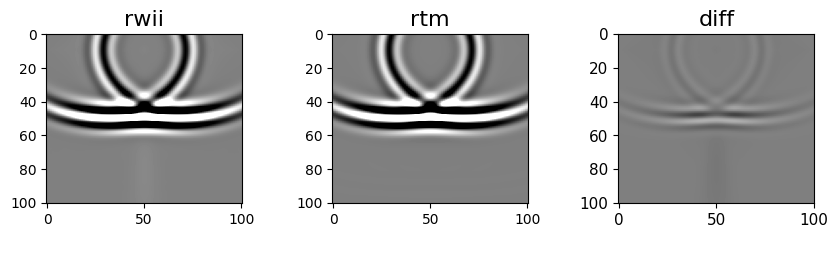

In [9]:
d = zeros(Float32, shape[1], shape[2], 3)
d[:,:,1] = rwii[:,:]
d[:,:,2] = reshape(g_adj, shape[1], shape[2])[:,:]
d[:,:,3] = (reshape(g_adj, shape[1], shape[2])-rwii)[:,:]

title = ["rwii", "rtm", "diff"]
MultiSeisPlotTX(d, title=title, cmap="gray", hbox=3, wbox=3, vmin=-1e12, vmax=1e12);